In [2]:
#Import standard data processing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Seaborn is a data visualization library built on matplotlib
import seaborn as sns

#Set the plotting style
sns.set_style("whitegrid")

In [3]:
#Read Excel and CSV data
edgap = pd.read_excel('..\data\EdGap_data.xlsx')
scores = pd.read_csv('..\data\ccd_sch_029_1617_w_1a_11212017.csv', encoding="unicode_escape", low_memory=False)

c:\Users\hrvel\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [4]:
edgap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7986 entries, 0 to 7985
Data columns (total 7 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   NCESSCH School ID                                7986 non-null   int64  
 1   CT Unemployment Rate                             7972 non-null   float64
 2   CT Pct Adults with College Degree                7973 non-null   float64
 3   CT Pct Childre In Married Couple Family          7961 non-null   float64
 4   CT Median Household Income                       7966 non-null   float64
 5   School ACT average (or equivalent if SAT score)  7986 non-null   float64
 6   School Pct Free and Reduced Lunch                7986 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 436.9 KB


The EdGap data contains just under 8 thousand entries for schools across the US that chose to share the requested economic data. The primary key for this data set is the NCESSCH ID.

In [5]:
scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102183 entries, 0 to 102182
Data columns (total 65 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   SCHOOL_YEAR          102183 non-null  object 
 1   FIPST                102183 non-null  int64  
 2   STATENAME            102183 non-null  object 
 3   ST                   102183 non-null  object 
 4   SCH_NAME             102183 non-null  object 
 5   LEA_NAME             102183 non-null  object 
 6   STATE_AGENCY_NO      102183 non-null  object 
 7   UNION                2533 non-null    float64
 8   ST_LEAID             102183 non-null  object 
 9   LEAID                102183 non-null  object 
 10  ST_SCHID             102183 non-null  object 
 11  NCESSCH              102181 non-null  float64
 12  SCHID                102181 non-null  float64
 13  MSTREET1             102181 non-null  object 
 14  MSTREET2             1825 non-null    object 
 15  MSTREET3         

The ACT and SAT scores have been reported by every school in the US which gives us over 100 thousand entries in this CSV. This data set also uses NCESSCH ID as a primary key, and can be used to join the two.

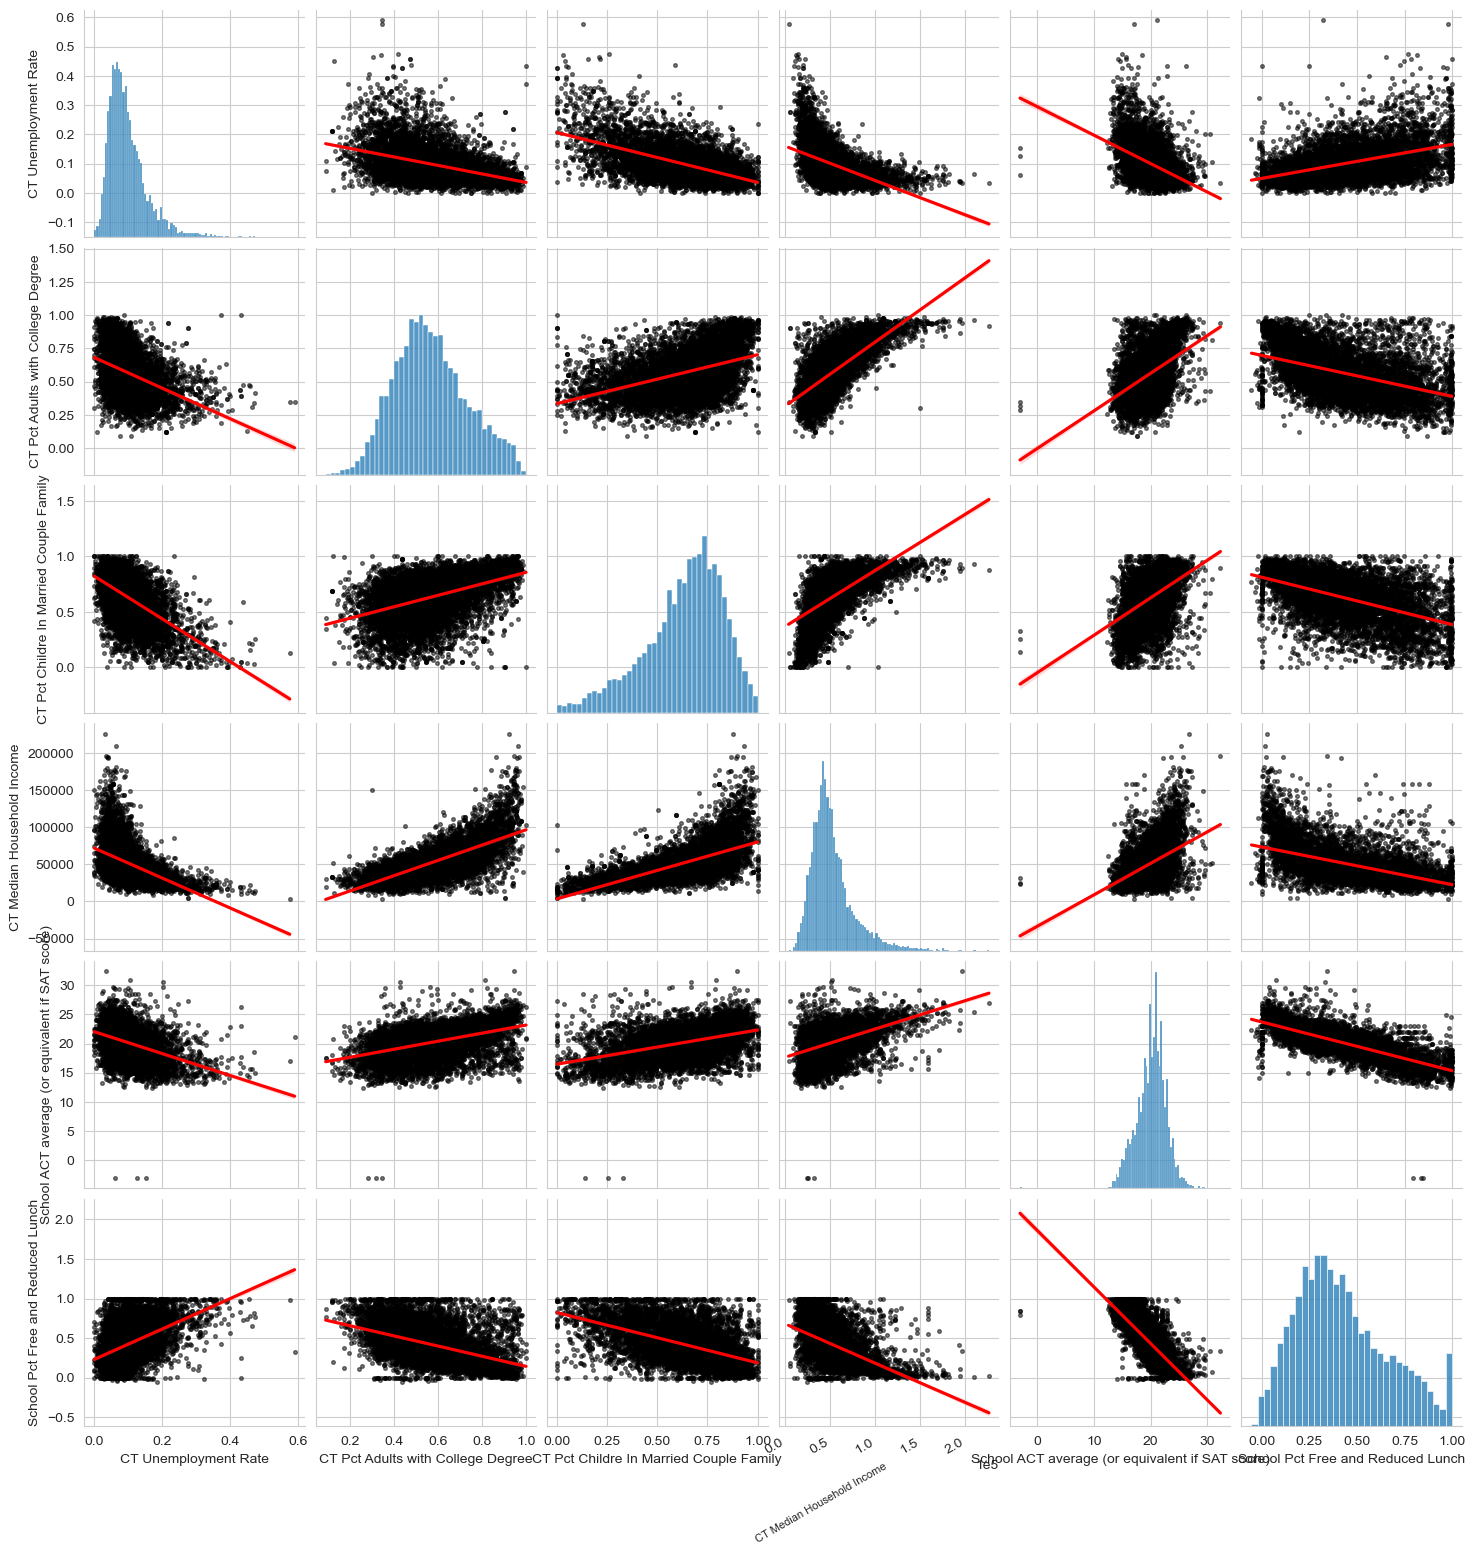

In [6]:
fig = sns.pairplot(
    edgap.drop(columns="NCESSCH School ID"),
    kind="reg",
    plot_kws={
            "line_kws":{"color":"red"},
            "scatter_kws":{"alpha":0.5, "color": "k", "s":7},
    },
)
for ax in fig.axes.flat:
    if ax.get_xlabel() == 'CT Median Household Income':
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0)) #Apply scientific notation
        ax.set_xlabel(ax.get_xlabel(), fontsize = 8, rotation=30, ha='right') #X-axis label and size rotation
        ax.set_ylabel(ax.get_ylabel(), fontsize = 8) #Y-axis label size

        plt.setp(ax.get_xticklabels(), rotation = 30, ha='right') #Rotate X-axis tick labels
            
;
plt.show()

In [7]:
school_information = scores[
    ['SCHOOL_YEAR', 'NCESSCH', 'LSTATE', 'LZIP', 'SCH_TYPE_TEXT', 'LEVEL', 'CHARTER_TEXT']
    ]
school_information.head()

,SCHOOL_YEAR,NCESSCH,LSTATE,LZIP,SCH_TYPE_TEXT,LEVEL,CHARTER_TEXT
0,2016-2017,1.000020e+10,AL,35220,Alternative School,High,No
1,2016-2017,1.000020e+10,AL,36067,Alternative School,High,No
2,2016-2017,1.000020e+10,AL,36784,Alternative School,High,No
3,2016-2017,1.000020e+10,AL,36057,Alternative School,High,No
4,2016-2017,1.000020e+10,AL,35206,Alternative School,High,No


In [8]:
edgap = edgap.rename(
    columns={
        "NCESSCH School ID":"id"
        , "CT Pct Adults with College Degree":"percent_college"
        , "CT Unemployment Rate":"rate_unemployment"
        , "CT Pct Childre In Married Couple Family":"percent_married"
        , "CT Median Household Income":"median_income"
        , "School ACT average (or equivalent if SAT score)":"average_act"
        , "School Pct Free and Reduced Lunch":"percent_lunch"
    }
)

In [9]:
edgap.head()

,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch
0,100001600143,0.117962,0.445283,0.346495,42820.0,20.433455,0.066901
1,100008000024,0.063984,0.662765,0.767619,89320.0,19.498168,0.112412
2,100008000225,0.056460,0.701864,0.713090,84140.0,19.554335,0.096816
3,100017000029,0.044739,0.692062,0.641283,56500.0,17.737485,0.296960
4,100018000040,0.077014,0.640060,0.834402,54015.0,18.245421,0.262641


In [10]:
school_information = school_information.rename(
    columns={
        "SCHOOL_YEAR":"year"
        , "NCESSCH":"id"
        , "LSTATE":"state"
        , "LZIP":"zip_code"
        , "SCH_TYPE_TEXT":"school_type"
        , "LEVEL":"school_level"
        , "CHARTER_TEXT":"charter"
    }
)

In [12]:
school_information['id'] = school_information['id'].astype('object')

In [13]:
school_information.head()

,year,id,state,zip_code,school_type,school_level,charter
0,2016-2017,10000200277.0,AL,35220,Alternative School,High,No
1,2016-2017,10000201667.0,AL,36067,Alternative School,High,No
2,2016-2017,10000201670.0,AL,36784,Alternative School,High,No
3,2016-2017,10000201705.0,AL,36057,Alternative School,High,No
4,2016-2017,10000201706.0,AL,35206,Alternative School,High,No


In [14]:
df = edgap.merge(
    school_information,
    how='left',
    on='id'
)

In [15]:
df.head()

,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch,year,state,zip_code,school_type,school_level,charter
0,100001600143,0.117962,0.445283,0.346495,42820.0,20.433455,0.066901,2016-2017,DE,19804,Regular School,High,Yes
1,100008000024,0.063984,0.662765,0.767619,89320.0,19.498168,0.112412,2016-2017,DE,19709,Regular School,High,No
2,100008000225,0.056460,0.701864,0.713090,84140.0,19.554335,0.096816,2016-2017,DE,19709,Regular School,High,No
3,100017000029,0.044739,0.692062,0.641283,56500.0,17.737485,0.296960,2016-2017,DE,19958,Regular School,High,No
4,100018000040,0.077014,0.640060,0.834402,54015.0,18.245421,0.262641,2016-2017,DE,19934,Regular School,High,No
